In [1]:
import numpy as np
import pandas as pd
import pylab as plt

import seaborn as sns
import pickle

import warnings

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet import diagnostics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Load Data

In [24]:
cons_df = pd.read_csv('./../../datasets/prod-region.csv', sep=';')

In [25]:
#reduce information
cons_df.drop(['Région', 'Code région', 'Plage de puissance injection', 'Filière de production', 'Nb points injection',
         'Total énergie injectée (Wh)', 'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
         'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
         'Indice représentativité Courbe n°1 + n°2 (%)', 'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
        axis='columns', inplace=True)
cons_df.dropna(inplace=True)
cons_df['Horodate'] = pd.to_datetime(cons_df['Horodate'].values, utc=True)
cons_df['Horodate'] = cons_df['Horodate'].dt.tz_localize(None)
#cons_df = cons_df.loc[cons_df['Horodate'] > '2020-06-01']
cons_df = cons_df.groupby('Horodate').sum().iloc[::-1]
cons_df = cons_df.reset_index()
cons_df.head(100)

Horodate  Courbe Moyenne n°1 + n°2 (Wh)
0  2021-12-31 22:30:00                            0.0
1  2021-12-31 22:00:00                            0.0
2  2021-12-31 21:30:00                            0.0
3  2021-12-31 21:00:00                            1.0
4  2021-12-31 20:30:00                            0.0
..                 ...                            ...
95 2021-12-29 23:00:00                            0.0
96 2021-12-29 22:30:00                            0.0
97 2021-12-29 22:00:00                            0.0
98 2021-12-29 21:30:00                            0.0
99 2021-12-29 21:00:00                            0.0

[100 rows x 2 columns]

In [26]:
#area graph (Date Vs Price)
import plotly.express as px
px.scatter(cons_df,
           x='Horodate',
           y='Courbe Moyenne n°1 + n°2 (Wh)')

## Simple Prophet Model

### Acquire and clean data

In [27]:
# Rename columns to fit the Prophet format
data = cons_df.rename(columns={'Horodate':'ds', 'Courbe Moyenne n°1 + n°2 (Wh)':'y'})
#data.to_csv('data.csv')

# Standardize the data
colx = ['y']

data_st = (data[colx] - data[colx].mean()) / data[colx].std()
#data_st = data
data_st['ds'] = data['ds']
data_st['cap'] = data_st['y'].max()*1.2
data_st['floor'] = data_st['y'].min()*1.1
#data_st.to_csv('data_st.csv')

In [28]:
data_st

y                  ds       cap     floor
0     -0.602202 2021-12-31 22:30:00  5.048478 -0.662422
1     -0.602202 2021-12-31 22:00:00  5.048478 -0.662422
2     -0.602202 2021-12-31 21:30:00  5.048478 -0.662422
3     -0.602202 2021-12-31 21:00:00  5.048478 -0.662422
4     -0.602202 2021-12-31 20:30:00  5.048478 -0.662422
...         ...                 ...       ...       ...
52586 -0.601307 2019-01-01 01:00:00  5.048478 -0.662422
52587 -0.601307 2019-01-01 00:30:00  5.048478 -0.662422
52588 -0.601307 2019-01-01 00:00:00  5.048478 -0.662422
52589 -0.601307 2018-12-31 23:30:00  5.048478 -0.662422
52590 -0.601307 2018-12-31 23:00:00  5.048478 -0.662422

[52591 rows x 4 columns]

## Train the model

In [29]:
# Create instance of model and train
prophet1 = Prophet(daily_seasonality=True,
                   weekly_seasonality=False,
                   yearly_seasonality=True,
                   seasonality_mode='additive',
                   growth="logistic")

prophet1.fit(data_st)

prophet1.stan_backend.logger = None
with open("prophet1.pickle", "wb") as f:
    pickle.dump(prophet1, f)

### Forecast future energy production

In [30]:
n_months = 12
n_days = n_months * 30
n_hours = (n_days * 24) * 2
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} half-hour".format(n_months, n_days, n_hours))

# Create dataframe containing future energy production predictions
pred_period1 = prophet1.make_future_dataframe(periods=n_hours, freq="30min")
pred_period1['cap'] = data_st['y'].max()*1.2
pred_period1['floor'] = data_st['y'].min()*1.1

preds1 = prophet1.predict(pred_period1)
#preds1.to_csv('preds1.csv')

We want to forecast:
 - 12 months, which is
 - 360 days, which is
 - 17280 half-hour


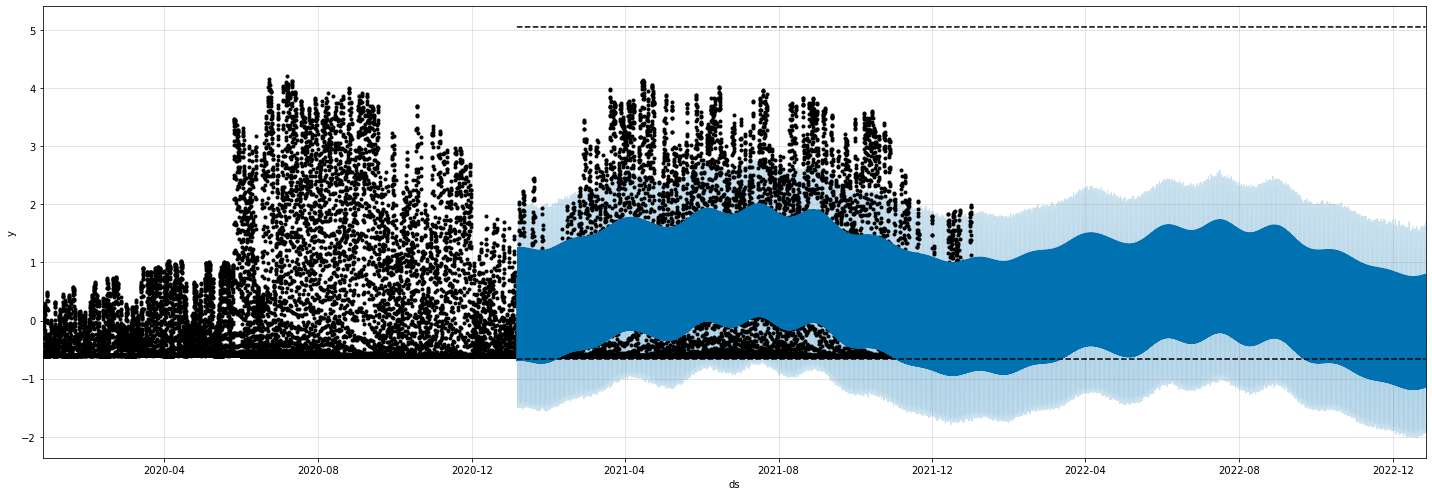

In [31]:
backtrack = (1 * 12 * 30 * 24) * 2
backtrack = int(backtrack)

fig = prophet1.plot(preds1[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds1.ds.values[-1] + np.timedelta64())
fig.show()

fig.savefig('prophet1_predictions.png')

In [32]:
def make_plot_block(preds, start, end, ax=None, xlabel='days'):

    # Truncate dataframes to only relevant portions
    actual = data_st.loc[(data_st.ds > start) & (data_st.ds < end), :].set_index('ds')
    forecast = preds.loc[(preds.ds > start) & (preds.ds < end), :].set_index('ds')

    actual.loc[:,'y'].plot(color='k', label='observations', ax=ax)
    forecast.loc[:,'yhat'].plot(color='steelblue', label='forecasts', ls='--', lw=3, ax=ax)
    ax.fill_between(forecast.index, forecast.loc[:,'yhat_lower'], forecast.loc[:,'yhat_upper'], color='steelblue', alpha=0.3)

    ax.grid(ls=':')
    ax.legend(fontsize=15)

    if xlabel == 'days':
        labels = [t.strftime('%b %d') for t in forecast.index]
    else:
        labels = [t.strftime("%b '") + t.strftime("%Y")[-2:] for t in forecast.index]
    ax.set_xticklabels(labels[::len(labels)//10], fontsize='large')

    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

    ax.set_ylabel('Energy Load', fontsize=15)
    ax.set_title(start + ' to ' + end, fontsize='xx-large')

def plot_seasons(preds, year):
    fig, ax = plt.subplots(4, 1, figsize=(20, 28))

    start = year + '-01-01'
    end = year + '-01-15'
    make_plot_block(preds, start, end, ax=ax[0], xlabel='days')

    start = year + '-04-01'
    end = year + '-04-15'
    make_plot_block(preds, start, end, ax=ax[1], xlabel='days')

    start = year + '-07-01'
    end = year + '-07-15'
    make_plot_block(preds, start, end, ax=ax[2], xlabel='days')

    start = year + '-10-01'
    end = year + '-10-15'
    make_plot_block(preds, start, end, ax=ax[3], xlabel='days')

    fig.subplots_adjust(hspace=0.35)
    return fig

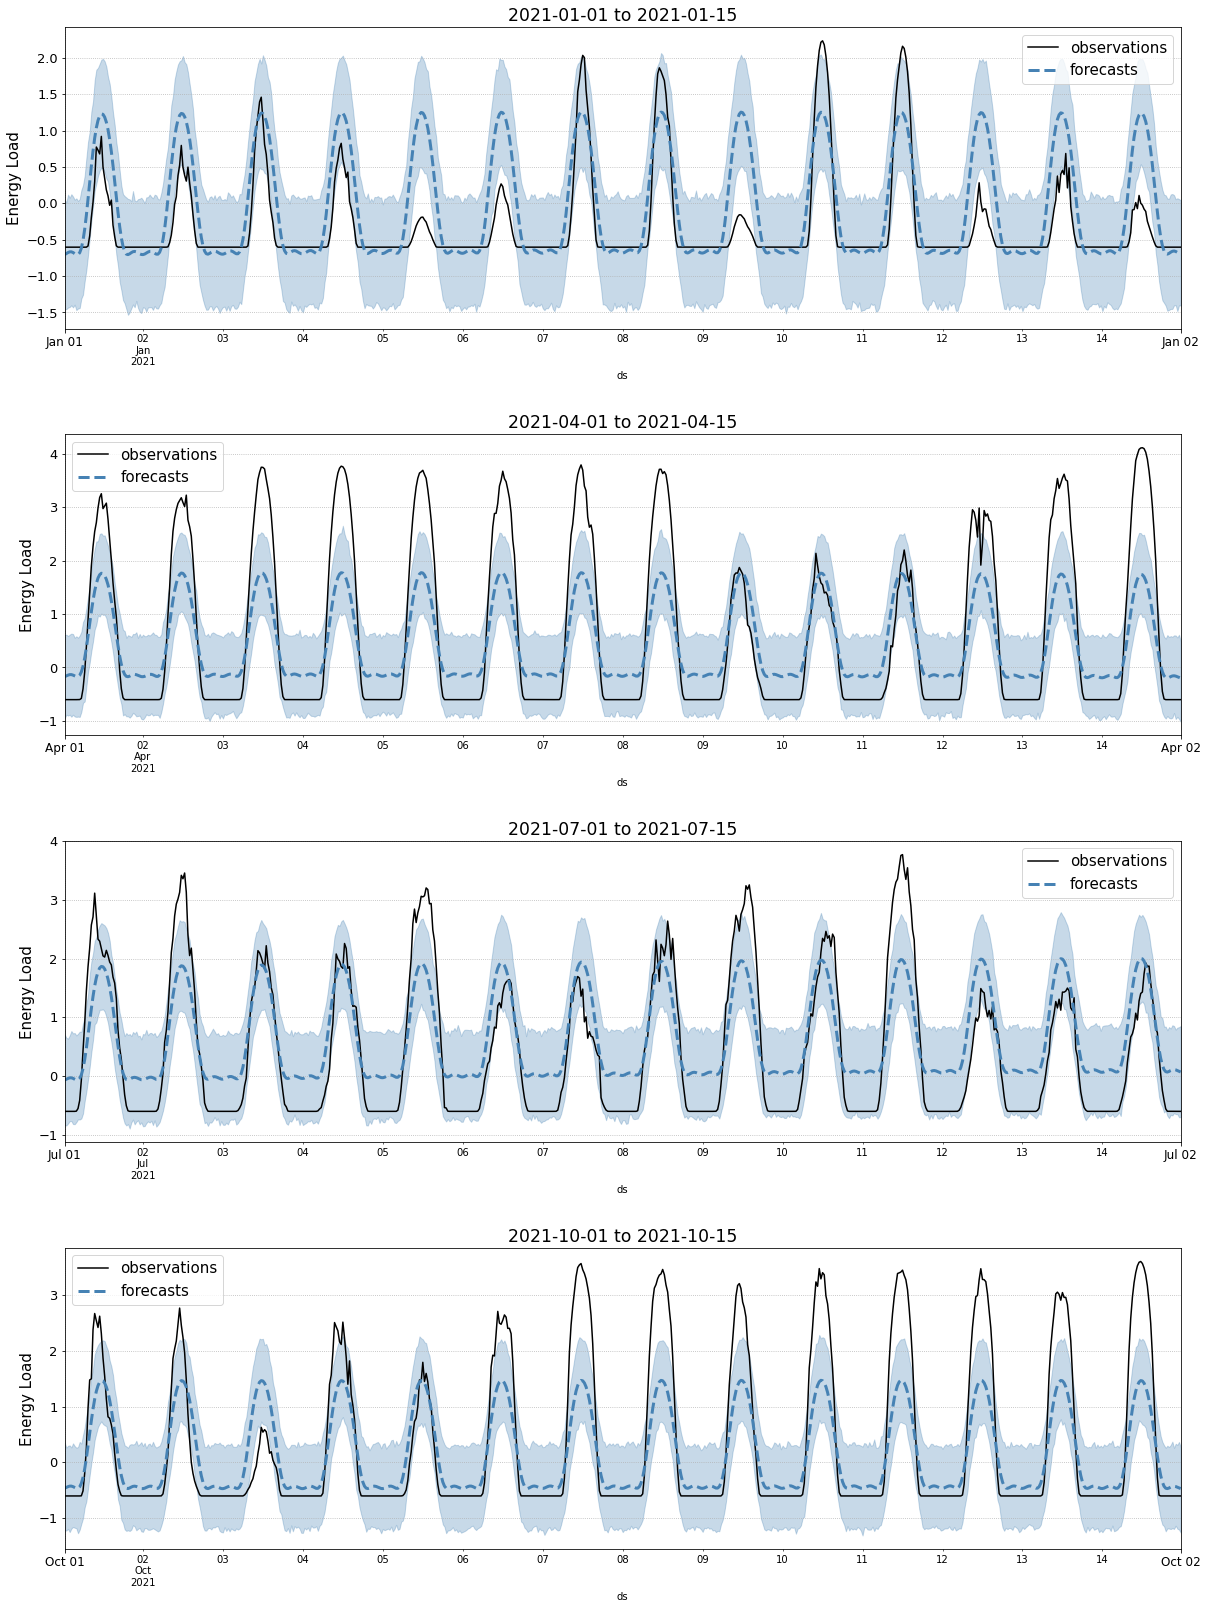

In [33]:
fig = plot_seasons(preds1, '2021')
fig.savefig('season_preds1.png')

### Examine the seasonality component of the model

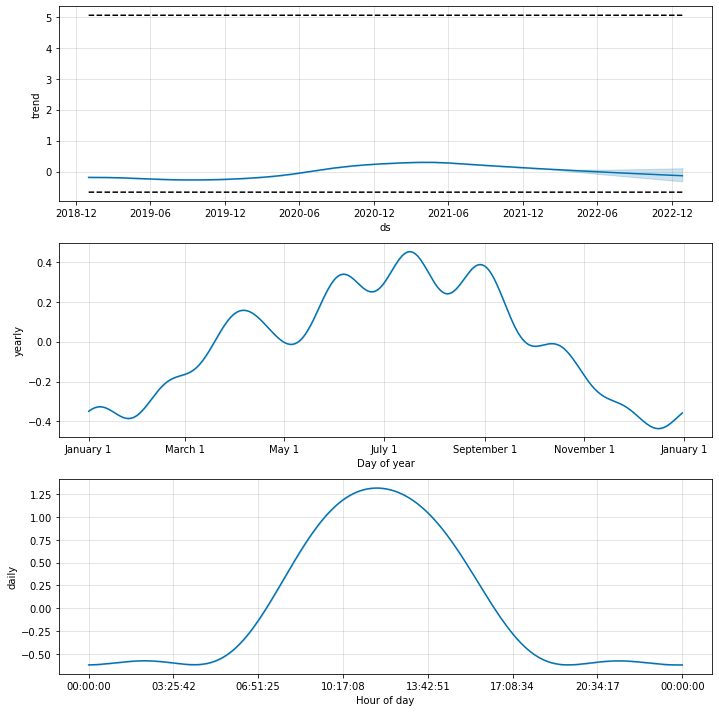

In [34]:
fig = prophet1.plot_components(preds1, figsize=(10, 10))
fig.savefig('prophet1_components.png')
fig.show()

### Model Validation

In [35]:
def mape(y_pred, y_true):
    ''' Mean average percent error statistic '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))

def unstandardize(y):
    return y * data.y.std() + data.y.mean()

In [36]:
result1_cv = diagnostics.cross_validation(prophet1, horizon="90 days")
result1_cv.to_csv('result1_cv.csv')

# Unstandardize the results
result1_cv_adj = result1_cv.copy()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
#check out forecast
result1_cv_adj.to_csv('result1_cv_adj.csv')

INFO:prophet:Making 15 forecasts with cutoffs between 2020-01-11 22:30:00 and 2021-10-02 22:30:00


  0%|          | 0/15 [00:00<?, ?it/s]

In [45]:
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    result1_cv_adj[col].clip(lower=0.0)

In [46]:
result1_day = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.day,
                                         result1_cv_adj.ds.dt.month,
                                         result1_cv_adj.ds.dt.year]).sum()
result1_month = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.month,
                                           result1_cv_adj.ds.dt.year]).sum()
result1_ag = result1_cv_adj.groupby('cutoff').sum()

print("Monthly mean average percent error: {:.2%}".format(mape(result1_month.yhat, result1_month.y)))
print("3-month mean average percent error: {:.2%}".format(mape(result1_ag.yhat, result1_ag.y)))

Monthly mean average percent error: 54.85%
3-month mean average percent error: 48.03%


In [58]:
result1_cv_adj[['ds', 'yhat']]

ds  yhat
0     2020-01-11 23:00:00   0.0
1     2020-01-11 23:30:00   0.0
2     2020-01-12 00:00:00   0.0
3     2020-01-12 00:30:00   0.0
4     2020-01-12 01:00:00   0.0
...                   ...   ...
64767 2021-12-31 20:30:00   0.0
64768 2021-12-31 21:00:00   0.0
64769 2021-12-31 21:30:00   0.0
64770 2021-12-31 22:00:00   0.0
64771 2021-12-31 22:30:00   0.0

[64772 rows x 2 columns]

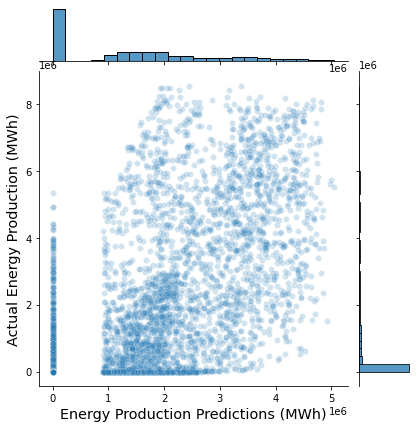

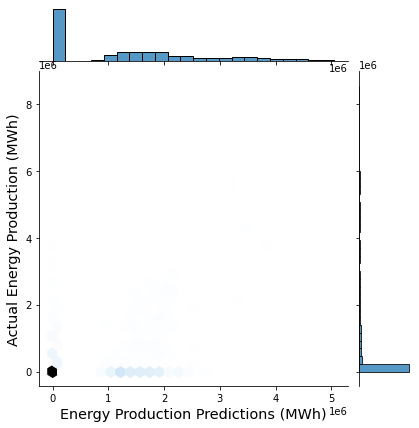

In [47]:
step = 10
grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_scatter1.png')

grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_hex1.png')

In [48]:
def plot_residuals(errs, fig=None, ax=None, display=True):
    if not fig:
        fig, ax = plt.subplots(figsize=(7, 7))
    sns.distplot(errs, bins=50, ax=ax)
    ax.set_title('Histogram of Prediction Residuals (Test Set)', fontsize='xx-large')
    plt.axvline(errs.median(), color='k', label='median')
    ax.set_xlabel('Error (MWh)', fontsize='xx-large')
    ax.set_yticks([])

    if display:
        ax.text(0.05, 0.9, "Median = {:+4.2f} MWh".
                format((errs).median()),
                fontsize=14, transform=ax.transAxes)
    return fig

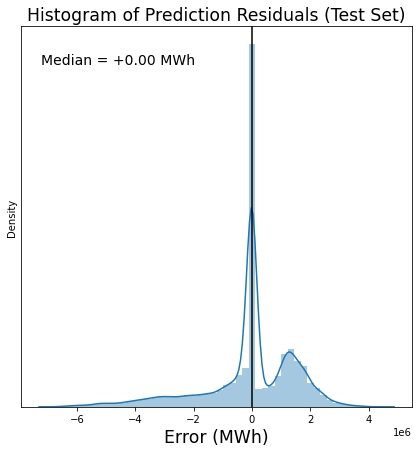

In [49]:
errs1 = result1_cv_adj.yhat - result1_cv_adj.y      # Units are now MWh, not standardized
fig = plot_residuals(errs1)
fig.savefig('residuals1_hist.png')
fig.show()

In [ ]:
print('The median error was {0:.2%} of the mean energy demand.'.format(errs1.median() / result1_cv_adj.y.mean()))

The median error was 0.00% of the mean energy demand.
